# Experiments for MIM

### Initialization

In [61]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
from sklearn import metrics
from skimage.color import gray2rgb, rgb2gray # since the code wants color images
from sklearn.linear_model import Ridge, lars_path, LinearRegression
from skimage.util.montage import montage2d # to make a nice montage of the images
import pandas as pan

## The influence measures

### Lime

This measure is adapted from the measure described in [Lime](https://arxiv.org/abs/1606.05386) the original code can be found [here](https://github.com/marcotcr/lime)

In [176]:
#Parameters 
# data   n*m array n = number of points m = dimension
# lables n array containing the classes
# number 0<number<n nuber of poi 
# kernel_width
# distance_metric 
def lime(data, lables, number, kernel_width=3.0, distance_metric='euclidean',random_state=None, verbose=True):
    poi = data[number]
    labels_column = np.asarray(pan.get_dummies(lables))[:,lables[number]];
    distances = metrics.pairwise_distances(
            data,
            poi.reshape(1, -1),
           metric=distance_metric
        ).ravel();
    kernel_width = float(kernel_width)
    def kernel(d):
        return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))
    weights = kernel(distances);
    model_regressor = Ridge(alpha=1, fit_intercept=True,
                                    random_state=random_state)
    easy_model = model_regressor
    easy_model.fit(data, labels_column, sample_weight=weights)
    prediction_score = easy_model.score(
            data,
            labels_column, sample_weight=weights)
    local_pred = easy_model.predict(poi.reshape(1, -1))
    if verbose:
        print(prediction_score)
        print(local_pred)
    return easy_model.coef_

### Parzen

This measure was described in [Beahrens et al](http://www.jmlr.org/papers/v11/baehrens10a.html).

In [159]:
def parzen(data, lables, number, sigma=4.7, distance_metric='euclidean'):
    def alpha(dist):
        sqrt2pi = np.sqrt(2*np.pi)
        return np.exp(-0.5*(dist*dist)/(sigma*sigma))/(sigma*sqrt2pi)
    poi = data[number];
    poi_label = lables[number];
    distances = metrics.pairwise_distances(
            data,
            poi.reshape(1, -1),
           metric=distance_metric
    ).ravel();
    totalSum = sum(alpha(distances))
    equalSum = sum(alpha(distances[lables == poi_label]))
    nonequalSum = sum(alpha(distances[lables != poi_label]))
    weightedNonequalSum = np.zeros(np.shape(poi))
    weightedEqualSum = np.zeros(np.shape(poi))
    for y in range(len(data)):
        if lables[y] == poi_label:
            weightedEqualSum = weightedEqualSum + alpha(distances[y])*(data[y]-poi)
        else:
            weightedNonequalSum = weightedNonequalSum + alpha(distances[y])*(data[y]-poi)
    return (weightedEqualSum*nonequalSum-weightedNonequalSum*equalSum)/(sigma ** 2 * totalSum ** 2)

### MIM

Finally, our own measure (or set of measures).

In [160]:
def mim(data, lables, number, distance_metric='euclidean', typ="quadratic"):
    def alpha(dist,typ):
        if typ=="linear":
            return dist;
        elif typ=="quadratic":
            return dist**2;
        elif typ=="exponential":
            return math.exp(dist);
    inf_vec = np.zeros(data[number].size);
    poi = data[number];
    poi_label = lables[number];
    distances = metrics.pairwise_distances(data,poi.reshape(1, -1),metric=distance_metric).ravel();
    for y in range(len(data)):
        diff = data[y] - poi;
        dist = distances[y];
        if dist!=0:
            if poi_label==lables[y]:
                inf_vec+=diff*1.0/alpha(dist,typ)
            else:
                inf_vec-=diff*1.0/alpha(dist,typ)
    return inf_vec

## Loading a dataset

We treat datasets as two vectors y_vec are the labels and X_vec contains the corresponding features.

### Facial Expression Recognition

The Facial Expression Recognition dataset can be obtained from [Kaggle](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data). We trimmed the dataset to only contain happy and sad faces.  

In [5]:
pictures = pan.read_csv("fer2013/fer2013.csv")

In [30]:
pictures = pan.read_csv("fer2013/fer2013.csv")
y_vec = pictures.emotion.astype(np.uint8)-3;
X_vec= np.stack([gray2rgb(np.asarray(pixel.split(' ')).astype(int).reshape(48,48)/256.0) for pixel in pictures.pixels
          ],0)

A look at some of the pictures

(-0.5, 479.5, 479.5, -0.5)

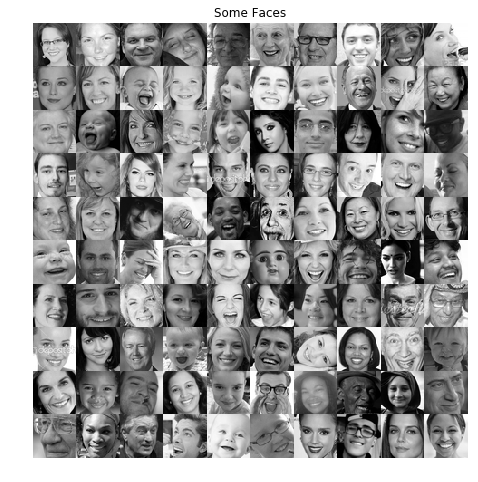

In [32]:
%matplotlib inline
#268#490
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
x=1
ax1.imshow(montage2d(X_vec[0:100,:,:,0]), cmap='gray', interpolation = 'none')
ax1.set_title('Some Faces')
ax1.axis('off')

For images it is nicer to visulize the influnce rather then printing a number for each pixel so here we define a function that can take the influence vector and create a color picture out of it. 

In [47]:
def influenceToColorpicture(infl):
    normalization  = np.amax(np.abs(infl))
    if normalization == 0:
        normalization = 1
    infl = infl/normalization;
    pos_coefs = np.copy(infl)
    pos_coefs[pos_coefs<0] = 0
    pos_coefs = gray2rgb(pos_coefs)
    pos_coefs[:,:,0] = 1 - pos_coefs[:,:,0];
    pos_coefs[:,:,1] = 1 - pos_coefs[:,:,1];
    pos_coefs[:,:,2] = 1;
    neg_coefs = np.copy(infl)
    neg_coefs[neg_coefs>0] = 0
    neg_coefs = gray2rgb(-neg_coefs);
    neg_coefs[:,:,0] = 1;
    neg_coefs[:,:,1] = 1 - neg_coefs[:,:,1];
    neg_coefs[:,:,2] = 1 - neg_coefs[:,:,2];
    new_coefs = neg_coefs+pos_coefs -1 
    return new_coefs

A function to overlay a image with it's influence. I.e. moving the picture according to it's influence. 

In [129]:
def overlay(img,infl):
    return img.reshape(48,48)+infl.reshape(48,48)/max(np.amax(np.abs(result)),0.000001)
    

Converting the data to the right format.

In [110]:
data = X_vec[:,:,:,0].flatten().reshape(len(y_vec),-1);
labels = y_vec;

Chosing a number. 

In [178]:
number = 268;

And plotting the results.

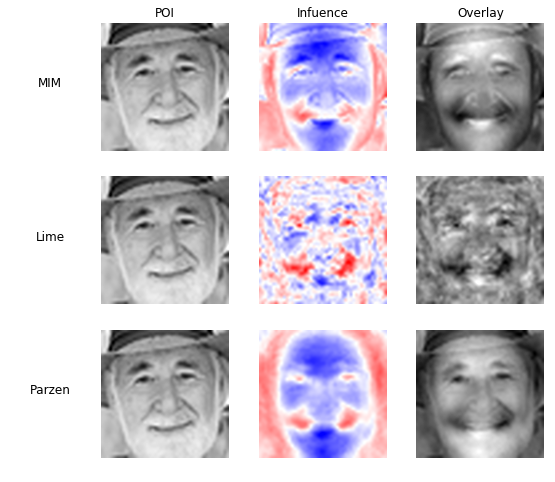

In [179]:
fig, axes = plt.subplots(3,3, figsize = (8,8))
#MIM
mim_infl = mim(data,labels,number)
axes[0,0].imshow(data[number].reshape(48,48),cmap='gray',  interpolation = 'spline36')
axes[0,2].imshow(overlay(data[number],mim_infl),cmap='gray',  interpolation = 'spline36')
axes[0,1].imshow(influenceToColorpicture(mim_infl.reshape(48,48)),  interpolation = 'spline36')
#Lime
lime_infl = lime(data,labels,number,verbose=False)
axes[1,0].imshow(data[number].reshape(48,48),cmap='gray',  interpolation = 'spline36')
axes[1,1].imshow(influenceToColorpicture(lime_infl.reshape(48,48)),  interpolation = 'spline36')
axes[1,2].imshow(overlay(data[number],lime_infl),cmap='gray',  interpolation = 'spline36')
#Parzen
parzen_infl = parzen(data,labels,number)
axes[2,0].imshow(data[number].reshape(48,48),cmap='gray',  interpolation = 'spline36')
axes[2,1].imshow(influenceToColorpicture(parzen_infl.reshape(48,48)),  interpolation = 'spline36')
axes[2,2].imshow(overlay(data[number],parzen_infl),cmap='gray',  interpolation = 'spline36')
#Formatting
axes[0,0].set_title('POI')
axes[0,1].set_title('Infuence')
axes[0,2].set_title('Overlay')
axes[0,0].annotate('MIM', xy=(0, 0.5), xycoords=axes[0,0].yaxis.label,size='large',ha='center')
axes[1,0].annotate('Lime', xy=(0, 0.5), xycoords=axes[1,0].yaxis.label,size='large',ha='center')
axes[2,0].annotate('Parzen', xy=(0, 0.5), xycoords=axes[2,0].yaxis.label,size='large',ha='center')
for x in axes.ravel():
    x.axis('off')
